In [1]:
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.ndimage import filters as flt

In [2]:
def array_from_dem(dem):
    
    src = rasterio.open(dem)
    arr = src.read(1)
    return arr

def compute_slope_from_2darr(arr):

    x, y = np.gradient(arr)
    slope_deg = np.rad2deg(np.arctan(np.sqrt(x * x + y * y)))
    return slope_deg

def compute_tpi_from_2d_arr(arr, win_size):
    """ Create an ArcGIS-like Terrain Prominence Index.
    Parameters
    ----------
    dem : ndarray
        Array of surface heights i.e. a DEM.
    win_size : int
        size of moving window to compute std. dev.
    Returns
    -------
    arc_tpi : ndarray
        Terrain Prominence map.
    """
    arr = np.ma.masked_equal(arr, np.nan)
    min_filt = flt.minimum_filter(arr, win_size)
    max_filt = flt.maximum_filter(arr, win_size)
    uni_filt = flt.uniform_filter(arr, win_size)
    
    tpi = (uni_filt - min_filt) / (max_filt - min_filt)
    return tpi


In [3]:
clpx = '/home/cparr/masters/DEMs/clpx/bare_earth/clpx_dem_final.tif'
hv = '/home/cparr/masters/DEMs/hv/bare_earth/hv_dem_final.tif'

In [4]:
clpx_dem = array_from_dem(clpx)
hv_dem = array_from_dem(hv)

In [5]:
clpx_slope = compute_slope_from_2darr(clpx_dem)
hv_slope = compute_slope_from_2darr(hv_dem)

In [6]:
clpx_area = np.count_nonzero(clpx_dem > -9999)
hv_area = np.count_nonzero(hv_dem > -9999)

In [7]:
hv_mask = (hv_dem == -9999)
hv_slope_new = np.copy(hv_slope)
hv_slope_new[hv_mask] = hv_dem[hv_mask]

clpx_mask = (clpx_dem == -9999)
clpx_slope_new = np.copy(clpx_slope)
clpx_slope_new[clpx_mask] = clpx_dem[clpx_mask]

print(np.count_nonzero(hv_slope_new > -9999) == hv_area)
print(np.count_nonzero(clpx_slope_new > -9999) == clpx_area)

True
True


In [8]:
slope_intervals = [(0,5), (5,10), (10,15), (15,30), (30,100)]

def count_arr_values_in_interval(arr, intervals, area):

    d = dict()
    for i in intervals:
        d[i] = ((i[0] < arr) & (arr < i[1])).sum() / area * 100
    
    return d

hv_slope_d = count_arr_values_in_interval(hv_slope_new, slope_intervals, hv_area)
clpx_slope_d = count_arr_values_in_interval(clpx_slope_new, slope_intervals, clpx_area)

In [9]:
hv_dem[hv_dem == -9999] = np.nan
clpx_dem[clpx_dem == -9999] = np.nan


hv_df = pd.DataFrame.from_dict(hv_slope_d, orient='index', columns=['HV']).T
print(hv_df.sum(axis=1))
hv_df['Mean Elevation'] = np.nanmean(hv_dem)
hv_df['Std. Dev Elevation'] = np.nanstd(hv_dem)
hv_df['Area [$km^2$]'] = hv_area / 1000000

clpx_df = pd.DataFrame.from_dict(clpx_slope_d, orient='index', columns=['CLPX']).T
print(clpx_df.sum(axis=1))
clpx_df['Mean Elevation'] = np.nanmean(clpx_dem)
clpx_df['Std. Dev Elevation'] = np.nanstd(clpx_dem)
clpx_df['Area [$km^2$]'] = clpx_area / 1000000

df = pd.concat([clpx_df, hv_df])
#df.round(2)

HV    99.999058
dtype: float64
CLPX    99.993106
dtype: float64


In [15]:
cols = ['% Area with Slope 0 to 5 Degrees',
        '% Area with Slope 5 to 10 Degrees',
        '% Area with Slope 10 to 15 Degrees',
        '% Area with Slope 15 to 30 Degrees',
        '% Area with Slope above 30 Degrees',
        'Mean Elevation [$m$]',
        'Std. Dev. Elevation [$m$]',
        'Total Area [$km^2$]']

df.columns = cols
df = df.round(1)


In [16]:
df

,% Area with Slope 0 to 5 Degrees,% Area with Slope 5 to 10 Degrees,% Area with Slope 10 to 15 Degrees,% Area with Slope 15 to 30 Degrees,% Area with Slope above 30 Degrees,Mean Elevation [$m$],Std. Dev. Elevation [$m$],Total Area [$km^2$]
CLPX,70.2,22.7,3.7,3.2,0.3,861.599976,53.400002,96.5
HV,84.5,14.4,0.8,0.1,0.1,382.000000,22.799999,29.0


In [17]:
df.to_csv('../../figs/fig_tabular_data/field_area_physio_comparison.csv')

/home/cparr/miniconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


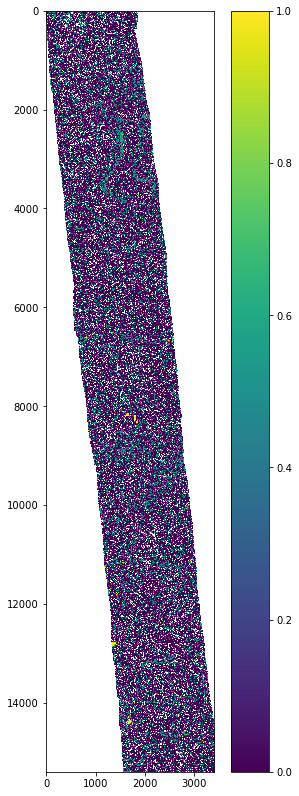

In [156]:
focal_sum_3x3 = np.full((9,9), 1.0)
dem_3x3_sum = filters.convolve(hv_dem, w)
dem_squared_3x3_sum = filters.convolve(hv_dem**2, w)
r2 = dem_squared_3x3_sum + (9 * hv_dem**2) - (2 * hv_dem * dem_3x3_sum)
rms_z_change = np.sqrt(r2)

plt.figure(figsize=(6,14))
plt.imshow(rms_z_change, vmin=0,vmax=1)
plt.colorbar()